In [2]:
from torchvision import transforms
from torch.utils.data import DataLoader

from utils.dataset import CustomDataset
from torchsampler import ImbalancedDatasetSampler

import torch
import torch.nn as nn
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import numpy as np 

from torchsummary import summary

from torch.nn import functional as F 

from tqdm import tqdm

import matplotlib.pyplot as plt

import sys
sys.path.append('../../')
from network import multi_models as models
from utils import loss 

from sklearn.metrics import recall_score, f1_score, accuracy_score

In [3]:
train_dir = '/home/eiden/eiden/DB/octc/data_multi_origin/train'
valid_dir = '/home/eiden/eiden/DB/octc/data_multi_origin/valid'



train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((324,324), antialias=True),
    transforms.RandomCrop(size = (224,224)),
    transforms.RandomRotation((0, 30), interpolation=transforms.InterpolationMode.NEAREST),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    # transforms.RandomResizedCrop(size = (224,224), antialias= True),
    
    # transforms.RandomApply([
    # transforms.RandomRotation(degrees=15),
    # transforms.RandomHorizontalFlip(p=0.5),
    # transforms.RandomVerticalFlip(p=0.5),
    # transforms.RandomResizedCrop(size=224, scale=(0.8, 1.0), ratio=(0.75, 1.33), antialias= True),
    # transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    # transforms.ColorJitter(brightness=0.2, contrast=0.2)
    # ], p=0.7),
])



valid_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224,224), antialias=True),
    # transforms.Resize((299,299), antialias=True),
    transforms.Grayscale(num_output_channels=3),
    # transforms.Normalize((0.5), (0.5)),
])
# batch
tr_batch = 3
vl_batch = 3


train_dataset = CustomDataset(root_dir = train_dir, transform= train_transform)
valid_dataset = CustomDataset(root_dir = valid_dir, transform= valid_transform)

# 배치샘플러 생성(1:1비율로 배치에 클래스 데이터 존재), DataLoader 생성
# balanced_batch_sampler = MultiClassBalancedBatchSampler(train_dataset, batch_size=tr_batch)
# balanced_batch_sampler = threeclassBalancedBatchSampler(train_dataset, batch_size=tr_batch)

train_loader = DataLoader(dataset=train_dataset, sampler=ImbalancedDatasetSampler(train_dataset, labels = train_dataset.getlabels()), batch_size = tr_batch,)
valid_loader = DataLoader(dataset = valid_dataset, batch_size = vl_batch, shuffle= False)
# train_loader = DataLoader(dataset = train_dataset, batch_size = tr_batch, shuffle= True)

{0.0: 2, 2.0: 1}


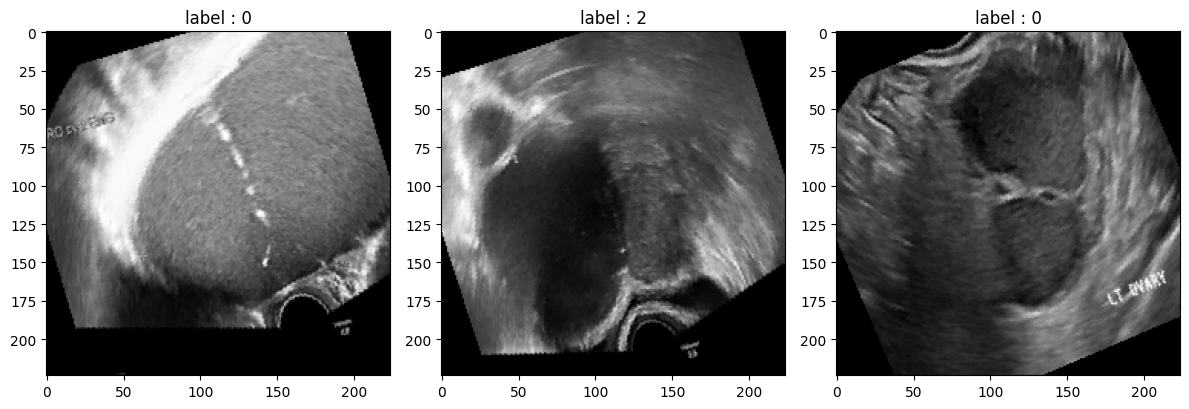

{1.0: 3}


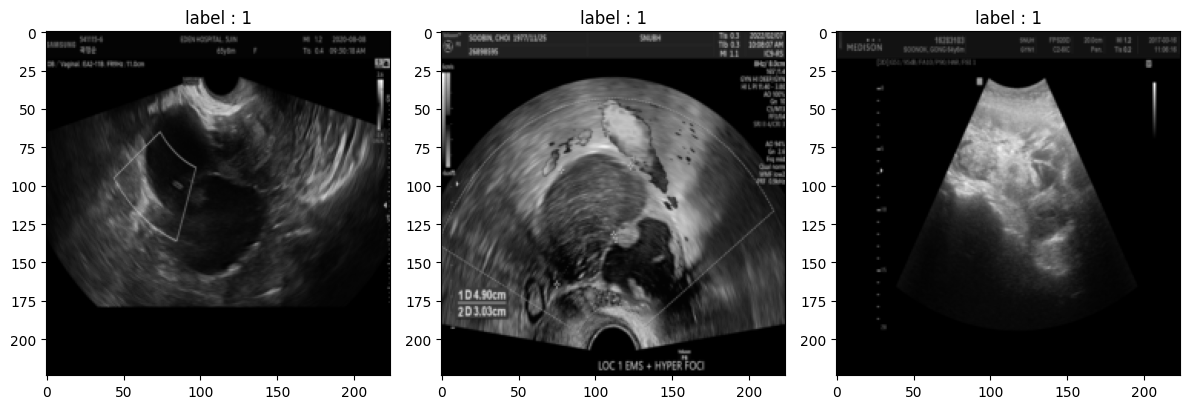

In [4]:
# batch sampler test
for i, (image, label) in enumerate(train_loader):
    unique, cnts = np.unique(label, return_counts= True)
    print(dict(zip(unique, cnts)))
    plt.figure(figsize= (12, 8))
    plt.subplot(131)
    plt.imshow(image[0,0], cmap ='gray')
    plt.title(f"label : {label[0].int().item()}")
    plt.subplot(132)
    plt.imshow(image[1,0], cmap ='gray')
    plt.title(f"label : {label[1].int().item()}")
    plt.subplot(133)
    plt.imshow(image[2,0], cmap ='gray')
    plt.title(f"label : {label[2].int().item()}")
    plt.tight_layout()
    plt.show()
    break
# batch sampler test
for i, (image, label) in enumerate(valid_loader):
    unique, cnts = np.unique(label, return_counts= True)
    print(dict(zip(unique, cnts)))
    plt.figure(figsize= (12, 8))
    plt.subplot(131)
    plt.imshow(image[0,0], cmap ='gray')
    plt.title(f"label : {label[0].int().item()}")
    plt.subplot(132)
    plt.imshow(image[1,0], cmap ='gray')
    plt.title(f"label : {label[1].int().item()}")
    plt.subplot(133)
    plt.imshow(image[2,0], cmap ='gray')
    plt.title(f"label : {label[2].int().item()}")
    plt.tight_layout()
    plt.show()
    break

In [5]:
import torch
import torch.nn as nn
from torchsummary import summary
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'
print(f'device : {device}')

pretrained_model = models.pretrained_convnext_multi()
pretrained_model.to(device)
# cost func & optimizer 정의
epoch, epochs = 0, 200
lr = 0.0001
# loss = custom_loss.FocalLoss().to(device)
loss = nn.CrossEntropyLoss().to(device) #-> 마지막 layer에 softmax/sigmoid 함수 넣어주기 

optimizer = torch.optim.AdamW(pretrained_model.parameters(), lr = lr)
# scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer = optimizer, lr_lambda = lambda epcoh: 0.95)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer = optimizer,
                                                        lr_lambda=lambda epoch: 0.95 ** epoch,
                                                        last_epoch = -1,
                                                        verbose= True)
# 모델 구조 출력 
print(f"cuda : {device}")
summary(pretrained_model, input_size=(3, 224, 224))

device : cuda


/home/eiden/anaconda3/envs/eiden/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Large_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


cuda : cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 192, 56, 56]           9,408
       LayerNorm2d-2          [-1, 192, 56, 56]             384
            Conv2d-3          [-1, 192, 56, 56]           9,600
           Permute-4          [-1, 56, 56, 192]               0
         LayerNorm-5          [-1, 56, 56, 192]             384
            Linear-6          [-1, 56, 56, 768]         148,224
              GELU-7          [-1, 56, 56, 768]               0
            Linear-8          [-1, 56, 56, 192]         147,648
           Permute-9          [-1, 192, 56, 56]               0
  StochasticDepth-10          [-1, 192, 56, 56]               0
          CNBlock-11          [-1, 192, 56, 56]               0
           Conv2d-12          [-1, 192, 56, 56]           9,600
          Permute-13          [-1, 56, 56, 192]               0
        LayerNorm-14       

/home/eiden/anaconda3/envs/eiden/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [6]:
metrics = {
    'train_loss' : [],
    'valid_loss' : [],
    'train_accuracy' : [],
    'train_f1' : [],
    'train_recall' : [],
    'valid_accuracy' : [],
    'valid_f1' : [],
    'valid_recall' : [],
}


In [7]:
# 조기 종료 변수 초기화
early_stopping_epochs, early_stop_cnt = 10, 0
best_loss = float('inf')


for epoch in tqdm(range(epoch, epochs)):
    
    train_losses = 0. 
    valid_losses = 0. 

    train_target, train_pred, valid_target, valid_pred = [],[],[],[]
    
    pretrained_model.train()
    for _, (inputs, labels) in tqdm(enumerate(train_loader)):
        optimizer.zero_grad() 
        inputs, labels = inputs.to(device), labels.type(torch.LongTensor).to(device)
        outputs = pretrained_model(inputs)
        train_loss = loss(outputs, labels)
        # print(train_loss)
        train_loss.backward()
        optimizer.step()
        train_losses += train_loss.item()
        
        # 예측 값을 이진 레이블로 변환
        pred = torch.argmax(outputs, dim = 1)
        train_target.extend(labels.detach().cpu().numpy())
        train_pred.extend(pred.detach().cpu().numpy())
        break 
    print(outputs, labels)
    metrics['train_loss'].append(train_losses/len(train_loader))
    
    metrics['train_accuracy'].append(0)
    metrics['train_f1'].append(0)
    metrics['train_recall'].append(0)
    # metrics['train_accuracy'].append(accuracy_score(train_target, train_pred))
    # metrics['train_f1'].append(f1_score(train_target, train_pred, pos_label=3))
    # metrics['train_recall'].append(recall_score(train_target, train_pred))
    
    scheduler.step()

    break
    
    with torch.no_grad():
        pretrained_model.eval()
        for _, (inputs, labels) in tqdm(enumerate(valid_loader)):
            inputs, labels = inputs.to(device), labels.type(torch.LongTensor).to(device)
            outputs = pretrained_model(inputs).float()
            valid_loss = loss(outputs, labels)
            valid_losses += valid_loss.item()
            
            # 예측 값을 이진 레이블로 변환
            pred = torch.argmax(outputs, dim = 1)
            
            valid_target.extend(labels.detach().cpu().numpy())
            valid_pred.extend(pred.detach().cpu().numpy())
        metrics['valid_loss'].append(valid_losses/len(valid_loader))
        metrics['valid_accuracy'].append(0)
        metrics['valid_f1'].append(0)
        metrics['valid_recall'].append(0)
        # metrics['valid_accuracy'].append(accuracy_score(valid_target, valid_pred))
        # metrics['valid_f1'].append(f1_score(valid_target, valid_pred))
        # metrics['valid_recall'].append(recall_score(valid_target, valid_pred))
    
    
    
    print("#"*100)    
    print(f"LOSS : {metrics['train_loss'][-1]} | {metrics['valid_loss'][-1]}\n ACC : {metrics['train_accuracy'][-1]} | {metrics['valid_accuracy'][-1]}\n F1 : {metrics['train_f1'][-1]} | {metrics['valid_f1'][-1]}\n RECALL : {metrics['train_recall'][-1]} | {metrics['valid_recall'][-1]}")
    print("#"*100)
    
    
        
    # Early Stopping
    if valid_loss > best_loss:
        early_stop_cnt += 1
    else:
        best_loss = valid_loss
        early_stop_cnt = 0
    
    # # 조기 종료 조건 확인
    # if early_stop_cnt >= early_stopping_epochs:
    #     print(f"Early Stops!!! : {epoch}/{epochs}")
        
    #     torch.save({
    #         "model" : f"{epoch}",
    #         "epoch" : epoch,
    #         "epochs" : epochs,
    #         "model_state_dict" : pretrained_model.state_dict(),
    #         "optimizer_state_dict" : optimizer.state_dict(),
    #         "learning_rate" : lr,
    #         "loss" : loss,
    #         "metric" : metrics,
    #         "description" : f"vggnet training status : {epoch}/{epochs}"
    #     },
    #     f'./metric/vgg16.pt')
        
    #     print(f"SAVE MODEL PATH : ./metric/@@@@@@.pt")
    #     break
    # else:
    #     if accuracy_score(valid_target, valid_pred) > np.array(metrics['valid_recall']).max():
    #         torch.save({
    #             "model" : f"{epoch}",
    #             "epoch" : epoch,
    #             "epochs" : epochs,
    #             "model_state_dict" : pretrained_model.state_dict(),
    #             "optimizer_state_dict" : optimizer.state_dict(),
    #             "learning_rate" : lr,
    #             "loss" : loss,
    #             "metric" : metrics,
    #             "description" : f"vggnet training status : {epoch}/{epochs}"
    #         },
    #         f'./metric/vgg16.pt')
            
    #         print(f"SAVE MODEL PATH : ./metric/@@@@@@.pt")


0it [00:00, ?it/s]/200 [00:00<?, ?it/s]
  0%|          | 0/200 [00:00<?, ?it/s]

tensor([[0.2871, 0.3475, 0.3654],
        [0.2940, 0.3469, 0.3591],
        [0.3190, 0.3371, 0.3439]], device='cuda:0', grad_fn=<SoftmaxBackward0>) tensor([2, 0, 1], device='cuda:0')
